In [6]:
import os


import torch
from torch import nn 
from torch.nn import functional as F 
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

import torchvision as tv


import warnings
warnings.filterwarnings('ignore') 

In [7]:
class cnf:
    IMG_SIZE = (180,180)
    BATCH_SIZE = 32
    SEED = 24
    TRAIN_SIZE = 0.9 
    
    
torch.manual_seed(cnf.SEED) 
np.random.seed(cnf.SEED)

In [8]:

def read_img(img_path):
    img = tv.io.read_image(img_path) 
    img = tv.transforms.functional.resize(img, cnf.IMG_SIZE)
    return img / 255.0
    
    

In [9]:
train_path = "/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train" 
test_path = "/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test"
data_path = "/kaggle/input/human-emotions-datasethes/EmotionsDataset/data"
data_splitted_train= "/kaggle/input/human-emotions-datasethes/EmotionsDataset_Splitted/data/train"
data_splitted_test = "/kaggle/input/human-emotions-datasethes/EmotionsDataset_Splitted/data/test"

label_map = {
    "angry" : 0,
    "happy" : 1,
    "sad" : 2,
    "nothing" : 3
}

def get_img_with_label(main_path):
    images = [] 
    labels = [] 
    subfolders = os.listdir(main_path) 
    for folder in subfolders:
        label = label_map[folder] 
        folder = os.path.join(main_path, folder) 
        
        for file in os.listdir(folder):
            if file.split(".")[-1].lower() in ['jpg', 'jpeg', 'png']: 
                file_path = os.path.join(folder, file)
                img = read_img(file_path) 
                if img.shape == (3,*cnf.IMG_SIZE):
                    images.append(img) 
                    labels.append(label) 
                
        
            
            
    return np.array(images), np.array(labels) 
    


paths = [train_path,test_path,data_path,data_splitted_train, data_splitted_test   ]


for i in range(len(paths)):
    if i==0:
        all_imgs, all_labels = get_img_with_label(paths[i]) 
    else:
        imgs, labels =  get_img_with_label(paths[i]) 
        all_imgs = np.concatenate((all_imgs, imgs), axis=0) 
        all_labels = np.concatenate((all_labels, labels), axis=0) 
        

In [10]:
print(all_imgs.shape) 
print(all_labels.shape) 

idx = np.random.permutation(len(all_imgs)) 

imgs = all_imgs[idx] 
labels = all_labels[idx] 


reverse_label  = {v:k for k,v in label_map.items()}


(15195, 3, 180, 180)
(15195,)


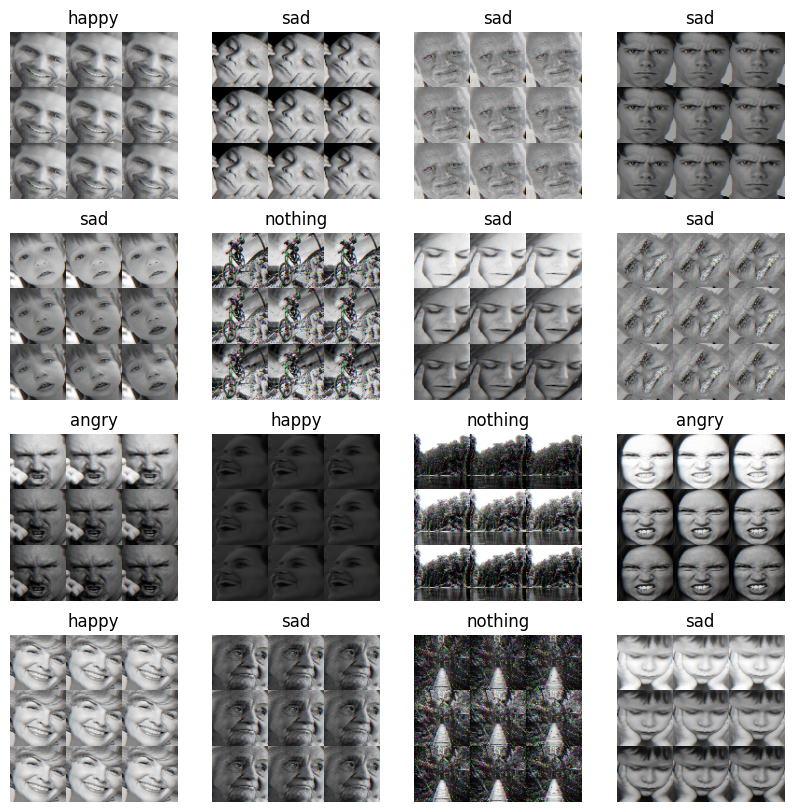

In [11]:
rows = 4
columns = 4

plt.figure(figsize=(10,10))
for i in range(rows*columns):
    plt.subplot(rows, columns, i+1) 
    plt.imshow(np.reshape(imgs[i], (*cnf.IMG_SIZE, 3))) 
    plt.title(f"{reverse_label[labels[i]]}")
    plt.axis('off')

In [12]:
n_train = int(len(all_imgs)*cnf.TRAIN_SIZE) 
train_imgs = imgs[:n_train] 
val_imgs = imgs[n_train:] 

train_labels = labels[:n_train]
val_labels = labels[n_train:] 


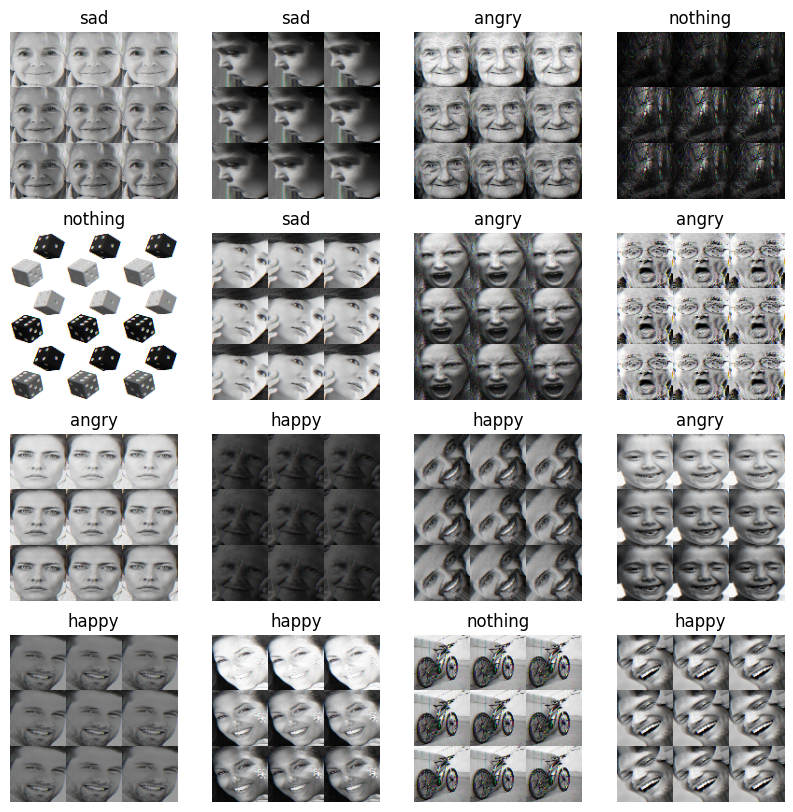

In [13]:
rows = 4
columns = 4

plt.figure(figsize=(10,10))
for i in range(rows*columns):
    plt.subplot(rows, columns, i+1) 
    plt.imshow(np.reshape(val_imgs[i], (*cnf.IMG_SIZE, 3))) 
    plt.title(f"{reverse_label[val_labels[i]]}")
    plt.axis('off')

In [14]:
class MakeDataset(Dataset):
    def __init__(self, imgs, labels):
        self.imgs = imgs
        self.labels = labels
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx] 
    
    
    
train_ds = MakeDataset(train_imgs, train_labels) 
val_ds = MakeDataset(val_imgs, val_labels)


train_dl = DataLoader(train_ds, batch_size=cnf.BATCH_SIZE) 
val_dl = DataLoader(val_ds, batch_size=cnf.BATCH_SIZE) 
        

In [15]:
for images, labels in train_dl:
    print(images.shape) 
    print(labels.shape) 
    
    break

torch.Size([32, 3, 180, 180])
torch.Size([32])


In [16]:
class CreateModel(nn.Module):
    def __init__(self, n_units):
        super(CreateModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1,padding=1 ) #same
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) #same
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(0.3) 
        self.dropout2 = nn.Dropout(0.3) 
        self.dropout3 = nn.Dropout(0.3) 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # hw -> hw/2 
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # hw -> hw/2 
        self.fc1 = nn.Linear(45*45*64, 128) 
        self.fc2 = nn.Linear(128,32) 
        self.fc3 = nn.Linear(32,n_units) 
        
        
    def forward(self, x):
        x = self.conv1(x) 
        x = self.bn1(x) 
        x = self.maxpool1(x) 
        x = self.dropout1(x) 
        x = self.conv2(x) 
        x = self.bn2(x) 
        x = self.maxpool2(x) 
        x = x.view(-1, 45*45*64)
        x = self.fc1(x) 
        x = F.relu(x)
        x = self.dropout2(x) 
        x = self.fc2(x) 
        x = F.relu(x) 
        x = self.bn3(x) 
        x = self.fc3(x) 
        return x
        
    
    

In [17]:
x = torch.randn(32,3,180,180) 
n_labels = len(np.unique(all_labels))
model = CreateModel(n_units=n_labels)

y = model(x)

y.shape

torch.Size([32, 4])

In [18]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

In [ ]:
num_epochs = 5

train_losses = [] 
total_accuracies = []

for epoch in range(num_epochs):
    for batch_data, batch_labels in tqdm(train_dl):
        model.train() 
        optimizer.zero_grad() 
        
        outputs = model(batch_data) 
        loss = loss_fn(outputs, batch_labels) 
        train_losses.append(loss) 
        
        loss.backward() 
        optimizer.step() 
        
    print(f"Epochs {epoch+1}, Loss : {loss.item():.3f}")

 96%|█████████▋| 413/428 [08:22<00:23,  1.57s/it]